# Neural Network Sin Wave Time Series Prediction

### Import Libraries
First we want to import all the libraries that we will be needing. They are grouped by their functionality.

In [1]:
# load and plot dataset
import pandas as pd #handles loading and editing data
from matplotlib import pyplot #handles plotting data

#Mathematical Operations
from sklearn.metrics import mean_squared_error #a computation of error through averaging the squared error
from sklearn.preprocessing import MinMaxScaler #Handles scaling between a and b

#Keras models
from keras.models import Sequential #neural network for a sequence of layers
from keras.layers import Dense #Standard neural network layer
from keras.layers import Activation #Non-linear functions in the neural network to make it non-linear.

import numpy as np

%matplotlib inline

Using TensorFlow backend.


Because some computations are random, we will suppress the randomness to have reproducable results

In [44]:
np.random.seed(7)
from tensorflow import set_random_seed
set_random_seed(2)

### Loading Data

1. We will use pandas, imported as pd, to read the csv, sine.csv.

2. We will then drop the first two rows because they are not numbers and are irrelevant to the sine function.

3. Then we delete the column angle, because angle and sine are the same columns and we only need one column containing the values of sine.

4. Then we ensure that the dataframe has float values.

5. We then plot the dataframe using the .plot() functionality that pandas DataFrames have.

6. We return df.head(5) to show the first 5 rows of what we have plotted

,sine
2,0.000000
3,0.062791
4,0.125333
5,0.187381
6,0.248690


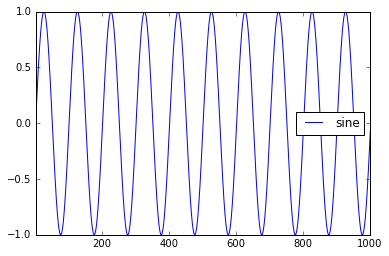

In [45]:
df = pd.read_csv('sine.csv')
df = df.drop([0, 1])
del df['angle']
df=df.astype(float)
df.plot()
df.head(5)

### Timeseries to Supervised
We have a function <strong>timeseries_to_supervised</strong> to convert time series data into a supervised dataset. What this means is that we make the dataset have a X and a Y, an input and an output. 

The original dataset is structured in one column containing values t_0, t_1, t_2, t_3, t_4, ... all the way to the end of the dataset.
In our case we have 6 inputs and 1 output. We convert it to a supervised learning set so each row is structured as 
t_0, t_1, t_2, t_3, t_4, t_5, t_6, where t_6 is the output, Y, and t_0, t_1, t_2, t_3, t_4, t_5 are X. The next row is shifted by one timestep, so we have a row containing t_1, t_2, t_3, t_4, t_5, t_6, t_7, where t_7 is the output, Y, and t_1 through t_6 are the inputs. Therefore, we now have a structure where the last 6 timesteps are used to evaluate the next timestep, a supervised learning structure where we have a clear input and output.

The function is written so that <strong>lag</strong> can be set, where lag is the number of timesteps in X.

In [46]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(lag+1 - i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

input_dim = 6
supervised = timeseries_to_supervised(df.values, input_dim)
supervised = supervised.drop(range(input_dim))
supervised.head()

,0,0,0,0,0,0,0
6,0.000000,0.062791,0.125333,0.187381,0.248690,0.309017,0.368125
7,0.062791,0.125333,0.187381,0.248690,0.309017,0.368125,0.425779
8,0.125333,0.187381,0.248690,0.309017,0.368125,0.425779,0.481754
9,0.187381,0.248690,0.309017,0.368125,0.425779,0.481754,0.535827
10,0.248690,0.309017,0.368125,0.425779,0.481754,0.535827,0.587785


1. We will get the values of this dataset in array form by calling .values on supervised, the DataFrame.
2. We create a MinMaxScaler object, giving a range of 0 to 1, the range it will scale the input dataset.
3. We fit the scaler to the values from supervised, so now the scaler knows to scale all values relative to the values from supervised. In otherwords, when scaling other data, we must input a set that has the same column size as the original.
4. We call scaler.transform to actually scale the data. scaler.transform returns a scaled data set whereas .fit only sets the settings for scaler.

In [47]:
data = supervised.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data = scaler.transform(data)

### Splitting into Trained and Tested
We will split the data into training and testing. First we calculate an integer for the index we will split at, split_num. Then we separate data into train and test. Because train and test are numpy arrays, we can further split by columns using python array slicing notation on a different axis. Finally, we will reshape x_train, y_train, x_test, and y_test because out model takes in a 3 dimentional input shape and not a 2 dimentional input shape.

In [48]:
split_test_size = 0.276
split_num = round(data.shape[0] * (1 - split_test_size))

train = data[:split_num]
test = data[split_num:]

x_train, y_train = train[:,:-1], train[:, -1:]
x_test, y_test = test[:, :-1], test[:, -1:]

x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

### Building the Model
Our model will have an input dimention, which we set above when we converted our dataset to a supervised problem, as 6. The model is a Sequential, meaning that it's a sequence of layers. After the first layer we apply the tanh function to what the first layer outputs in order to eliminate linearity. We feed that to a 5 node Dense layer and then into a relu function. After that we feed it to a 3 node Dense layer and then an output layer of 1 node because we will be outputing one value, the value at the next timestep.

We compile the model using a loss function of mean_squared_error and we use the optimizer algorithm of adam. Optimizers are algorithms for neural networks that will attempt to minimize the loss, which in our case is calculated by mean_squared_error.

In [49]:
model = Sequential()

model.add(Dense(input_dim, input_shape=(1, input_dim)))
model.add(Activation("tanh"))
model.add(Dense(5))
model.add(Activation("relu"))
model.add(Dense(3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

Finally we fit our values for x and y. We will run this 200 times and shuffle our training values every time. 

In [50]:
model.fit(x_train, y_train, epochs=200, verbose=2, shuffle=True)

Epoch 1/200
0s - loss: 0.3602
Epoch 2/200
0s - loss: 0.3044
Epoch 3/200
0s - loss: 0.2534
Epoch 4/200
0s - loss: 0.2060
Epoch 5/200
0s - loss: 0.1645
Epoch 6/200
0s - loss: 0.1290
Epoch 7/200
0s - loss: 0.0985
Epoch 8/200
0s - loss: 0.0746
Epoch 9/200
0s - loss: 0.0549
Epoch 10/200
0s - loss: 0.0404
Epoch 11/200
0s - loss: 0.0291
Epoch 12/200
0s - loss: 0.0210
Epoch 13/200
0s - loss: 0.0148
Epoch 14/200
0s - loss: 0.0106
Epoch 15/200
0s - loss: 0.0075
Epoch 16/200
0s - loss: 0.0054
Epoch 17/200
0s - loss: 0.0038
Epoch 18/200
0s - loss: 0.0027
Epoch 19/200
0s - loss: 0.0020
Epoch 20/200
0s - loss: 0.0014
Epoch 21/200
0s - loss: 0.0011
Epoch 22/200
0s - loss: 7.7539e-04
Epoch 23/200
0s - loss: 5.8573e-04
Epoch 24/200
0s - loss: 4.3505e-04
Epoch 25/200
0s - loss: 3.2776e-04
Epoch 26/200
0s - loss: 2.5305e-04
Epoch 27/200
0s - loss: 1.9222e-04
Epoch 28/200
0s - loss: 1.5379e-04
Epoch 29/200
0s - loss: 1.2268e-04
Epoch 30/200
0s - loss: 1.0217e-04
Epoch 31/200
0s - loss: 7.7553e-05
Epoch 32

After 200 rounds we got a very low loss, which is very good. However this is a sin function that has no noise, so in real world applications we expect more loss. 

### Testing the Model
We will now predict the values for sin given our x_test set using model.predict
In order to see if our predictions are accurate, we compare it to the real values in y_test. In order to plot it, we first must flatten our dataset, as .plot does not take 3D shapes.

In [51]:
predictions = model.predict(x_test)

We set the title of the graph using pyplot and plot pred and real, giving them labels. In order to show the labels we call pyplot.legend() and then show the plot using pyplot.show().

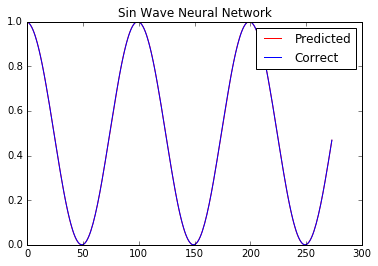

In [52]:
pred = predictions.flatten()
real = y_test.flatten()
pyplot.title('Sin Wave Neural Network')
pyplot.plot(pred, 'r-', label='Predicted')
pyplot.plot(real, 'b-', label='Correct')
pyplot.legend()
pyplot.show()

### Testing the Model's Long Term Prediction Accuracy

Something we need to note is that this is very deceptively accurate depending on your application. We have two uses for time series, the first is prediction the future and the second is detecting anomalies. What the previous evaluation did is use x values to predict the next timestep, t+1 for given the last few timesteps, t, t-1, t-2, etc. 

In order to detect anomalies this is fine because anomaly detection is about making a prediction for the next few time steps and detecting the difference between what we predicted/expected and what we actually got. 

However, when we want to predict far into the future, we need to test the accuracy in a different way. We will use t-5, t-4, t-3, t-2, t-1, t to predict t+1 first. With the predicted value, we then use t-4, t-3, t-2, t-1, t, t+1 to predict t+2. However the error in each prediction amplifies because it affects the next prediction. Let's test this.


In [53]:
predictions = []
last_predicted = None
for t in x_test:
    if last_predicted == None:
        last_predicted = t.reshape(1, 1, input_dim)[:,:,1:]
        y_pred = model.predict(t.reshape(1, 1, input_dim), batch_size=1)
        last_predicted = np.append(last_predicted, y_pred)
        predictions.append(y_pred)
    else:
        y_pred = model.predict(last_predicted.reshape(1, 1, input_dim), batch_size=1)
        last_predicted = np.append(last_predicted[1:], y_pred)
        predictions.append(y_pred)
        
predictions = np.array(predictions)

/Users/Home/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


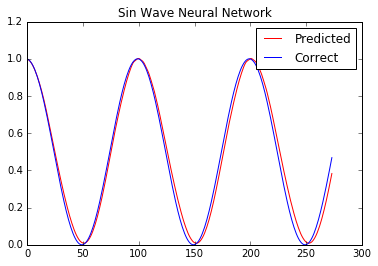

In [54]:
#Temperature Predictions
pred = predictions.flatten()
real = y_test.flatten()

pyplot.title('Sin Wave Neural Network')
pyplot.plot(pred, 'r-', label='Predicted')
pyplot.plot(real, 'b-', label='Correct')
pyplot.legend()
pyplot.show()

Thus, we have predicted the next 250 timesteps, but it's far more innacurate.